In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

In [2]:
mnist_train = pd.read_csv('./fashion-mnist_train.csv')
mnist_test = pd.read_csv('./fashion-mnist_test.csv')


In [3]:
mnist_train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [4]:
X_train, y_train, X_test, y_test = mnist_train.iloc[:,1:], mnist_train['label'], mnist_test.iloc[:,1:], mnist_test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train.shape

(60000, 784)

In [6]:
y_train.shape

(60000,)

In [7]:
def plot_samples(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


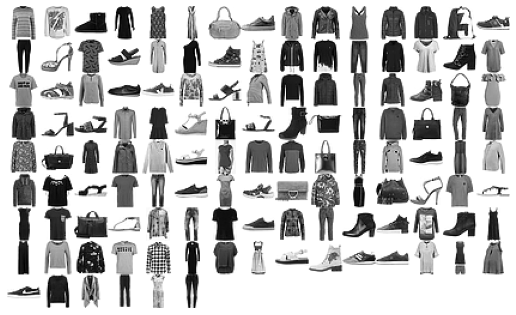

In [8]:
plt.figure(figsize=(9,9))
example_images = X_train[14:140]
plot_samples(example_images.values, images_per_row=15)
plt.show()

In [9]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split( X_train, y_train, test_size=0.1, random_state=21)

In [10]:
print(x_train_data.shape)

print(y_train_data.shape)

(54000, 784)
(54000,)


In [11]:

pca = PCA(n_components=0.9, random_state=0,svd_solver='full')

x_train_data_pca = pca.fit_transform(x_train_data)
x_test_data_pca = pca.transform(x_test_data)
original_X_test_pca = pca.transform(X_test)


pca.n_components_


84

## pre processing

In [12]:

scaling_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('pca',PCA(n_components=0.90, random_state=0,svd_solver='full')),       
    ]
)

x_train_scaled = scaling_pipeline.fit_transform(x_train_data)
x_test_scaled = scaling_pipeline.transform(x_test_data)
original_X_test_scaled = scaling_pipeline.transform(X_test)


## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_scaled,y_train_data)
knn_clf.score(x_test_scaled,y_test_data)


0.8651666666666666

### Tunning KNN

In [14]:
knn_param_grid =     {
     'n_neighbors': list(range(3,100,10)),
     'weights':['uniform','distance'],
     'metric': ['euclidean','manhattan','minkowski'],
    }

In [15]:
knn_grid_search = RandomizedSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    knn_param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0
)
knn_grid_search.fit(x_train_scaled,y_train_data)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None, n_jobs=-1,
                                                  n_neighbors=5, p=2,
                                                  weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': [3, 13, 23, 33, 43, 53,
                                                        63, 73, 83, 93],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train

In [16]:
knn_grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')

In [17]:
knn_grid_search.best_score_

0.8577777777777778

## Random Forest 

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)


forest_clf.fit(x_train_scaled,y_train_data)
forest_clf.score(x_test_scaled,y_test_data)


0.8676666666666667

### Tunning randomForest

In [19]:
forest_params = {
     'n_estimators': [100,200,400],
     'max_depth':[None,30,100],
     'max_features': ['auto','sqrt','log2'],
     'random_state':[0]
}

In [20]:
forest_grid_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1),
    forest_params,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    random_state=0
)

forest_grid_search.fit(x_train_scaled,y_train_data)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [21]:
forest_grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
forest_grid_search.best_score_

0.8672777777777778

In [23]:
best_forest = forest_grid_search.best_estimator_

## XGBoost

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

In [25]:
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=6,gamma = 0,colsample_bytree = 0.8)

xgb_clf.fit(x_train_scaled,y_train_data)
xgb_clf.score(x_test_scaled,y_test_data)

0.8706666666666667

### Tunning XGBoost

In [26]:
xgb_params = {
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    gamma = 0,
    colsample_bytree = 0.8)

XGBGridsearch = RandomizedSearchCV(xgb_clf, xgb_params,scoring='accuracy',cv=3, random_state=0,n_jobs=-1)
XGBGridsearch.fit(x_train_scaled,y_train_data)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [27]:
XGBGridsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
XGBGridsearch.best_score_

0.8870185185185185

In [39]:
best_xgb = XGBGridsearch.best_estimator_
print(best_xgb.score(original_X_test_scaled,y_test))

print(classification_report(best_xgb.predict(original_X_test_scaled),y_test))

0.8958
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1054
           1       0.98      0.99      0.99       984
           2       0.83      0.84      0.84       988
           3       0.92      0.90      0.91      1027
           4       0.87      0.83      0.85      1044
           5       0.94      0.96      0.95       975
           6       0.67      0.77      0.72       878
           7       0.94      0.92      0.93      1022
           8       0.98      0.96      0.97      1018
           9       0.95      0.94      0.95      1010

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000



## Stacking

In [30]:
from sklearn.ensemble import StackingClassifier

In [31]:
stacking_clf = StackingClassifier(estimators=[
    ('knn', knn_grid_search.best_estimator_),
    ('rf', best_forest)], final_estimator=best_xgb)

stacking_clf.fit(x_train_scaled,y_train_data)

StackingClassifier(cv=None,
                   estimators=[('knn',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=13,
                                                     p=2, weights='uniform')),
                               ('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=30,
                                                       max_features='sqrt',
                   

In [32]:
stacking_clf.score(original_X_test_scaled,y_test)

0.8796

In [33]:
print(classification_report(stacking_clf.predict(original_X_test_scaled),y_test))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1038
           1       0.97      0.98      0.98       990
           2       0.80      0.82      0.81       971
           3       0.91      0.90      0.91      1015
           4       0.85      0.80      0.83      1058
           5       0.93      0.96      0.94       969
           6       0.66      0.71      0.68       924
           7       0.93      0.91      0.92      1020
           8       0.97      0.97      0.97      1004
           9       0.93      0.92      0.93      1011

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



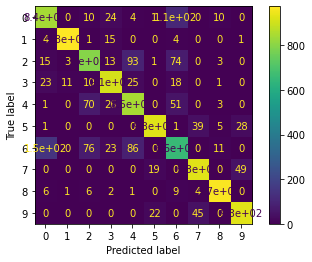

In [34]:
plot_confusion_matrix(stacking_clf,original_X_test_scaled,y_test)

In [36]:
from sklearn.ensemble import VotingClassifier

In [40]:
voting_clf = VotingClassifier(
    estimators=[('knn',knn_grid_search.best_estimator_),
                ('rf',best_forest),
                ('xgb',best_xgb)],
            voting='soft',
            weights=[1,1,3],
)

voting_clf.fit(x_train_scaled,y_train_data)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=13,
                                                   p=2, weights='uniform')),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=30,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
 

In [41]:
voting_clf.score(original_X_test_scaled,y_test)

0.8959